# 决策树和随机森林 —— 以 Titanic 数据集为例

https://www.kaggle.com/c/titanic

In [18]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## 一棵二分类决策树


In [19]:
from sklearn import tree
from sklearn.model_selection import train_test_split


X = df[['Sex','Age','SibSp']]
y = df['Survived']
SEX_MAPPING = {'male': 0, 'female': 1}
X = X.replace({'Sex': SEX_MAPPING})
X.Age = X.Age.fillna(X.Age.median())

X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                      test_size=0.25,
                                                      random_state=33)

clf = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy')
clf = clf.fit(X_train, y_train)

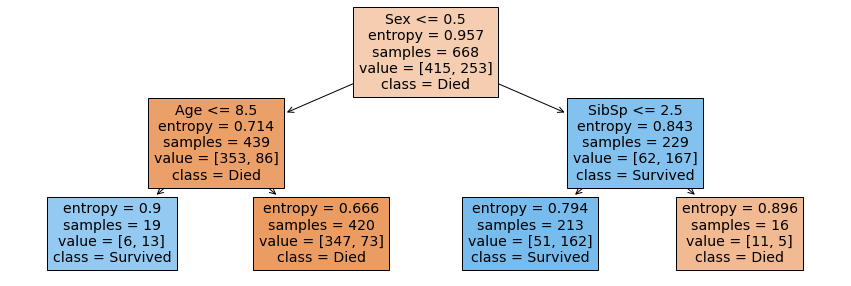

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns, 
                   class_names=['Died', 'Survived'],
                   filled=True,
                   impurity=True) 

## 划分选择

### 计算信息增益、信息增益率、基尼指数

In [4]:
from math import log

def entropy(y):
    '''熵，度量数据集的不确定性，只依赖 y 的分布'''
    return sum([-p*log(p) for p in y.value_counts() / y.count()])

def information_gain(series, y):
    '''信息增益，表示得知特征 series 的信息，而使数据集的不确定性减少的程度'''
    weighted_entropies = [y[series == v].count() / y.count() * entropy(y[series == v]) 
                          for v in series.unique()]
    return entropy(y) - sum(weighted_entropies)

def entropy_A(series, y):
    '''特征 series 的熵'''
    percentages = [y[series == v].count() / y.count() for v in series.unique()]
    return sum([-p*log(p) for p in percentages])

def gain_ratio(series, y):
    '''信息增益率'''
    return information_gain(series, y) / entropy_A(series, y)

def gini(y):
    '''基尼值'''
    return 1 - sum([p*p for p in y.value_counts() / y.count()])

def gini_index(series, y):
    '''基尼指数'''
    return sum([y[series == v].count() / y.count() * gini(y[series == v]) 
                for v in series.unique()])


print('根结点的熵：', round(entropy(y_train),3))
print('根结点的基尼值：', round(gini(y_train),3))


data = [[attr, 
         information_gain(X_train[attr], y_train),
         entropy_A(X_train[attr], y_train),
         gain_ratio(X_train[attr], y_train),
         gini_index(X_train[attr], y_train)] 
        for attr in ('Sex', 'Age', 'SibSp')]
pd.DataFrame(
    data, 
    columns=['特征', '信息增益', '关于特征的熵', '信息增益率', '基尼指数'])

根结点的熵： 0.663
根结点的基尼值： 0.471


,特征,信息增益,关于特征的熵,信息增益率,基尼指数
0,Sex,0.138156,0.642885,0.214900,0.342415
1,Age,0.084644,3.586821,0.023599,0.402329
2,SibSp,0.018790,0.884366,0.021247,0.454349


## 剪枝处理

### 增加决策树深度后，训练集和验证集上的精度变化

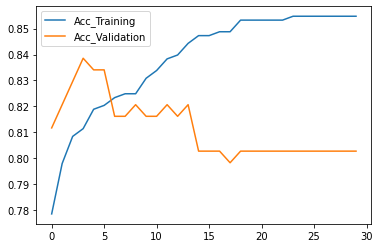

In [5]:
acc = []
for depth in range(1, 31):
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    clf = clf.fit(X_train, y_train)
    acc.append((clf.score(X_train, y_train), clf.score(X_valid, y_valid)))
_ = pd.DataFrame(acc, columns=['Acc_Training', 'Acc_Validation']).plot.line()

### 剪枝处理后，在验证集上的精度得到提升

剪枝处理前的精度： ('训练集：0.808', '验证集：0.83')
剪枝处理后的精度： ('训练集：0.805', '验证集：0.843')


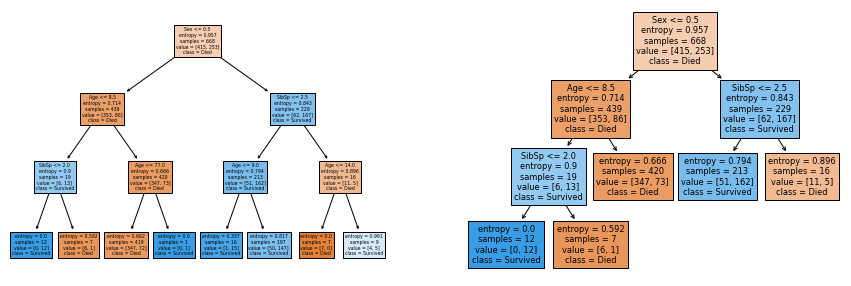

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

def train_and_plot(ax, min_impurity_decrease):
    clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy',
                                      min_impurity_decrease=min_impurity_decrease)
    clf = clf.fit(X_train, y_train)
    _ = tree.plot_tree(clf, 
                       feature_names=X.columns, 
                       class_names=['Died', 'Survived'],
                       filled=True,
                       impurity=True,
                       ax=ax) 
    return ('训练集：%s' % round(clf.score(X_train, y_train), 3), 
            '验证集：%s' % round(clf.score(X_valid, y_valid), 3))

print('剪枝处理前的精度：', train_and_plot(axes[0], min_impurity_decrease=0))
print('剪枝处理后的精度：', train_and_plot(axes[1], min_impurity_decrease=0.01))

# 集成学习

## AdaBoost

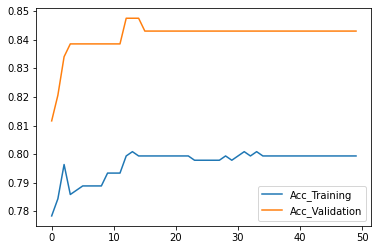

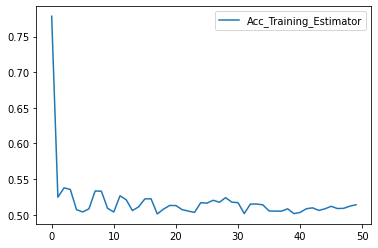

In [7]:
from sklearn.ensemble import AdaBoostClassifier

acc = []
acc_estimators = []
for n in range(1,51,1):
    bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1, criterion='entropy'),
                             algorithm="SAMME.R",
                             n_estimators=n,
                             learning_rate=1)
    bdt.fit(X_train, y_train)
    acc.append((bdt.score(X_train, y_train), bdt.score(X_valid, y_valid)))

_ = pd.DataFrame(acc, columns=['Acc_Training', 'Acc_Validation']).plot.line()
_ = pd.DataFrame(1-bdt.estimator_errors_, columns=['Acc_Training_Estimator']).plot.line()

In [8]:
len(bdt.estimators_)

50

## 随机森林

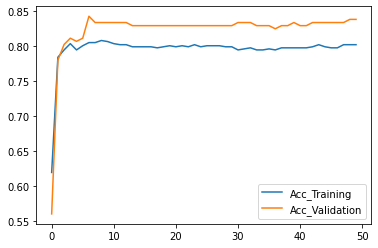

In [9]:
from sklearn.ensemble import RandomForestClassifier
acc = []
for n in range(1,51,1):
    rf = RandomForestClassifier(n_estimators=n, max_depth=2, random_state=3)
    rf.fit(X_train, y_train)
    acc.append((rf.score(X_train, y_train), rf.score(X_valid, y_valid)))
_ = pd.DataFrame(acc, columns=['Acc_Training', 'Acc_Validation']).plot.line()

In [12]:
rf.feature_importances_

array([0.5211357, 0.3315026, 0.1473617])

In [23]:
df = pd.read_csv('data/test.csv')
X_test = df[['Sex','Age','SibSp']]
X_test = X_test.replace({'Sex': SEX_MAPPING})
X_test.Age = X_test.Age.fillna(X.Age.median())

y_pred = clf.predict(X_test)

In [20]:
clf.predict

<bound method BaseDecisionTree.predict of DecisionTreeClassifier(criterion='entropy', max_depth=2)>

In [24]:
df = pd.read_csv('data/test.csv')

In [29]:
for a,b in zip(df.PassengerId, y_pred):
    print('{},{}'.format(a,b))

892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,1
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,1
926,0
927,0
928,1
929,1
930,0
931,0
932,0
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,0
943,0
944,1
945,0
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,0
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,1
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,1
10